In [169]:
import mplfinance as mpf
import pandas as pd
from pathlib import Path
import numpy as np
import datetime

In [172]:
# Get BTC OHLCV dataframe
df = pd.read_csv(Path("Resources/BTC-USD.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)
display(df.head())
display(df.tail())

FileNotFoundError: [Errno 2] No such file or directory: 'Resources\\BTC-USD.csv'

In [3]:
# Slice of double bottom
intra = df.loc['12-16-2020':'02-17-2021']
intra.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-16,19418.818359,21458.908203,19298.316406,21310.597656,21310.597656,4.440901e+10
2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,7.137861e+10
2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,4.038790e+10
2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,3.848755e+10
2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,3.784423e+10


In [4]:
import plotly.graph_objects as go

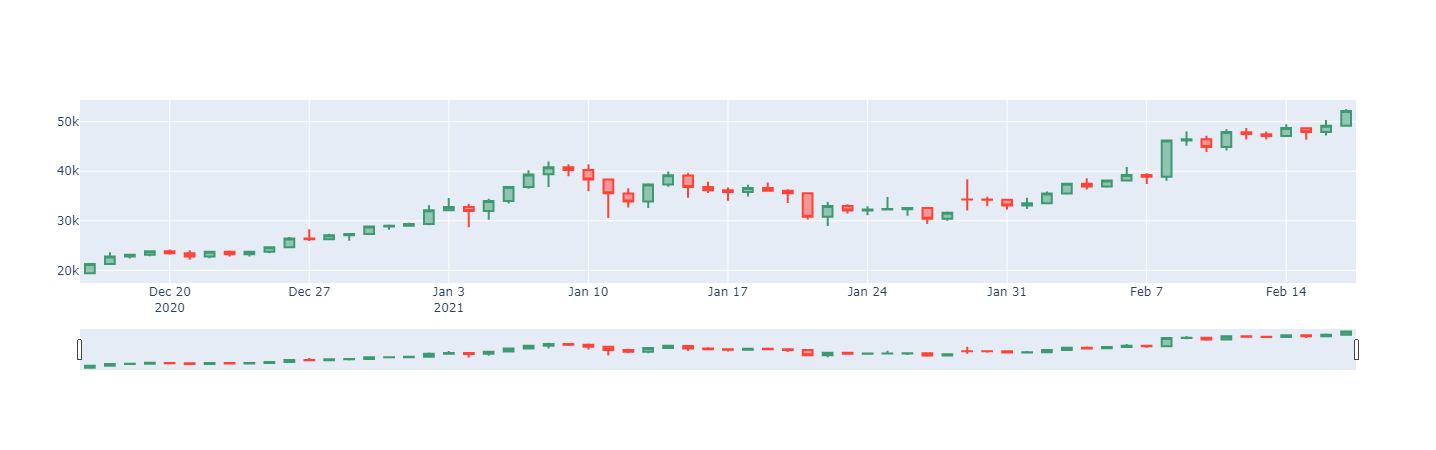

In [26]:
# Use plotly to plot candlesticks
fig = go.Figure(data=[go.Candlestick(x=intra.index,
                open=intra['Open'],
                high=intra['High'],
                low=intra['Low'],
                close=intra['Close'])])

fig.show()

In [92]:
intra.head(40)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-16,19418.818359,21458.908203,19298.316406,21310.597656,21310.597656,4.440901e+10
2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,7.137861e+10
2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,4.038790e+10
2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,3.848755e+10
2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,3.784423e+10
2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,4.585271e+10
2020-12-22,22794.039063,23789.902344,22430.605469,23783.029297,23783.029297,4.417163e+10
2020-12-23,23781.974609,24024.490234,22802.646484,23241.345703,23241.345703,5.114616e+10
2020-12-24,23240.203125,23768.337891,22777.597656,23735.949219,23735.949219,4.108076e+10


In [136]:
# Store local max and min ranges
localmin_range = {}
localmax_range = {}

In [120]:
# Check if there is a previous bar
def update_cert(cert, index, df):
    # Create certifying candle
    # count number of null values to see if is first row
    null_count = 0
    for value in cert.values():
        if value == None:
            null_count += 1
    
    # update prev dictionary if all null values
    # if first row it will update with those values
    if null_count == 5:
        cert['t'] = index
        cert['o'] = float(df.loc[index]['Open'])
        cert['c'] = float(df.loc[index]['Close'])
        cert['h'] = float(df.loc[index]['High'])
        cert['l'] = float(df.loc[index]['Low'])
        
        # return the certying candle dictionary
        return cert
    
    # update prev with new prev values (new prev is old curr)
    else:
        if index + datetime.timedelta(days=1):
            cert['t'] = (index)
            cert['o'] = float(df.loc[index]['Open'])
            cert['c'] = float(df.loc[index]['Close'])
            cert['h'] = float(df.loc[index]['High'])
            cert['l'] = float(df.loc[index]['Low'])
        
            # return the certying candle dictionary
            return cert
# c[c.iloc[:, 0] == 1]
        
def update_curr(curr, index, df):
    # Create current dictionary of current candle
    idx = df.index  
    
    # format datetime index
    dt_object = (index - datetime.timedelta(days=1)).to_datetime64()
#     print(type(idx))
    
#     print(sum(df.index == dt_object))
    
    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=1)
        curr['t'] = (index)
        curr['o'] = float(df.loc[index]['Open'])
        curr['c'] = float(df.loc[index]['Close'])
        curr['h'] = float(df.loc[index]['High'])
        curr['l'] = float(df.loc[index]['Low'])
        
        # return the current candle dictionary
        return curr
    else:
        pass
        
def update_prev(prev, index, df):
    # Create the previous candle
    idx = df.index
    

    dt_object = (index - datetime.timedelta(days=2)).to_datetime64()

#     print(sum(df.index == dt_object) )
    if sum(df.index == dt_object) > 0:
        index -= datetime.timedelta(days=2)
        prev['t'] = (index)
        prev['o'] = float(df.loc[index]['Open'])
        prev['c'] = float(df.loc[index]['Close'])
        prev['h'] = float(df.loc[index]['High'])
        prev['l'] = float(df.loc[index]['Low'])
        
        # return the previous candle dictionary
        return prev
    else:
        pass

In [158]:
localmax_range = {}

# Get candles data to find local max's min's

# store previous candle
prev = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None   
}

# store current candle
curr = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None 
}

# store certifying candle (certifies if the max/min is created)
cert = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None 
}



# Init counters
max_counter = 0
key_counter = 0

for index in intra.index:
    cert_candle = update_cert(cert, index, intra)
    curr_candle = update_curr(curr, index, intra)
    prev_candle = update_prev(prev, index, intra)
    print(f"Third candle: {prev_candle} \nSecond candle: {curr_candle} \nFirst candle: {cert_candle} \n")
    
    # make max counter
    
    
    # create dict to store candle information
    max_dict = {}
    
    # to make dictionary keys
    
    
    if curr_candle and prev_candle:
        # get local max
        if (curr_candle['c'] > cert_candle['c']) & (curr_candle['c'] > prev_candle['c']):
            max_dict = curr_candle
#             max_dict['counter'] = max_counter
            
            localmax_range[key_counter] = max_dict
            df = pd.DataFrame(localmax_range).T
            df.set_index(df['t'], inplace=True)
#             display(df)
#             key_counter += 1
#             max_counter += 1

Third candle: None 
Second candle: None 
First candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 

Third candle: None 
Second candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 
First candle: {'t': Timestamp('2020-12-17 00:00:00'), 'o': 21308.351563, 'c': 22805.162109, 'h': 23642.660156, 'l': 21234.675781} 

Third candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 
Second candle: {'t': Timestamp('2020-12-17 00:00:00'), 'o': 21308.351563, 'c': 22805.162109, 'h': 23642.660156, 'l': 21234.675781} 
First candle: {'t': Timestamp('2020-12-18 00:00:00'), 'o': 22806.796875, 'c': 23137.960938, 'h': 23238.601563, 'l': 22399.8125} 

Third candle: {'t': Timestamp('2020-12-17 00:00:00'), 'o': 21308.351563, 'c': 22805.162109, 'h': 23642.660156, 'l': 21234.675781} 
Second candle: {'t'

In [165]:
localmin_range = {}

prev = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None   
}

# store current candle
curr = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None 
}

# store certifying candle (certifies if the max/min is created)
cert = {
    't' : None,
    'o' : None,
    'c' : None,
    'h' : None,
    'l' : None 
}

double_bottom = {'a': None, 'b': None, 'c': None, 'd': None, 'e': None}

for index in intra.index:
    cert_candle = update_cert(cert, index, intra)
    curr_candle = update_curr(curr, index, intra)
    prev_candle = update_prev(prev, index, intra)
    
    
    # make max counter
    
    
    # create dict to store candle information
#     min_dict = {}
    
    # to make dictionary keys
    
    
#     if curr_candle and prev_candle:
#         # get local min
#         if (curr_candle['c'] < cert_candle['c']) & (curr_candle['c'] < prev_candle['c']):
#             min_dict = curr_candle
# #             max_dict['counter'] = max_counter
    localmin_range[key_counter] = find_min(cert_candle, curr_candle, prev_candle)
    
#     previous_low = 
    # store point b
    double_bottom['b'] = find_min(cert_candle, curr_candle, prev_candle)

    print(double_bottom)
    print(f"Third candle: {prev_candle} \nSecond candle: {curr_candle} \nFirst candle: {cert_candle} \n")
#     df_min = pd.DataFrame(localmin_range).T
#     df_min.set_index(df_min['t'], inplace=True)
#             print(df_min)

{'a': None, 'b': None, 'c': None, 'd': None, 'e': None}
Third candle: None 
Second candle: None 
First candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 

{'a': None, 'b': None, 'c': None, 'd': None, 'e': None}
Third candle: None 
Second candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 
First candle: {'t': Timestamp('2020-12-17 00:00:00'), 'o': 21308.351563, 'c': 22805.162109, 'h': 23642.660156, 'l': 21234.675781} 

{'a': None, 'b': None, 'c': None, 'd': None, 'e': None}
Third candle: {'t': Timestamp('2020-12-16 00:00:00'), 'o': 19418.818359, 'c': 21310.597656, 'h': 21458.908203, 'l': 19298.316406} 
Second candle: {'t': Timestamp('2020-12-17 00:00:00'), 'o': 21308.351563, 'c': 22805.162109, 'h': 23642.660156, 'l': 21234.675781} 
First candle: {'t': Timestamp('2020-12-18 00:00:00'), 'o': 22806.796875, 'c': 23137.960938, 'h': 23238.601563, '

In [ ]:
# potentially put in previous high as another variable

# b and d must be found to find c, a and e.



# point b is a local min 
# and point c is a local max that is greater than b and less than a
# and point d is less than c and in the range (it's close or wick) of b (close and low wick)
# and e closes above c
# BUY



In [42]:
# Logic to store double bottom points
# logic to break pattern
# Logic for entry
# Make another column called max and min

In [160]:
def find_max(cert_candle, curr_candle, prev_candle):
    # get local max
    max_dict = {}
    if curr_candle and prev_candle:       
        if (curr_candle['c'] > cert_candle['c']) & (curr_candle['c'] > prev_candle['c']):
            max_dict = curr_candle
            return max_dict
        
def find_min(cert_candle, curr_candle, prev_candle):   
    # get local min
    min_dict = {}
    if curr_candle and prev_candle:
        if (curr_candle['c'] < cert_candle['c']) & (curr_candle['c'] < prev_candle['c']):
            min_dict = curr_candle
            return min_dict